In [115]:
#python libraries
import os
import re
from datetime import datetime
import pytz

#other ML libraries
import pandas as pd
import numpy as np

#ploting
import matplotlib.pyplot as plt
%matplotlib inline

In [116]:
result_file = open("./cfg/house.csv")

#Skipping first two lines
result_file.readline()
result_file.readline()

period = result_file.readline().split()[2:10]

zone_names = result_file.readline().split()
temp_map = {key:[] for key in zone_names}
start_day, start_month, year = period[3].split('/')
start_day, start_month, year = int(start_day), int(start_month), int(year) + 2000
counter = 1
while measured_temp := result_file.readline().split():
    for i, value in enumerate(measured_temp):
        if(i == 0):
            time = value
            hour, min = time.split('h')
            hour, min = int(hour), int(min)
            day = start_day + counter//24
            if day > 31: #TODO: Brute force, FIX
                day = 1
            month = start_month + counter//(24*31)
            datetime_obj = datetime(year=year, month=month, day=day, hour=hour, minute=min, tzinfo=pytz.timezone('Etc/GMT-2'))
            temp_map[zone_names[i]].append(datetime_obj)
        else:
            temp = value
            temp_map[zone_names[i]].append(float(temp))
    counter += 1

In [117]:
#Import Disruptive & Netatmo Sensor Data

# assign variables
directory = './storedData/'
sensor_data = pd.DataFrame()
sensor_data['timestamp'] = None #in order to merge based on it 

measurement_types_skip = ["Door", "Water", "Humidity_temperature", "Humidity_humidity"]


# iterate over files in that directory and concat into 1 big dataframe based on timestamps
for filename in os.listdir(directory): 
    file = os.path.join(directory, filename)
    if os.path.isfile(file):    
        df = pd.read_csv(file)
        df.drop(columns=df.columns[0], inplace=True) # dropping unnamed coloumn for indexing in .cvs file

        df['timestamp'] = pd.to_datetime(df['timestamp'],  utc=True).dt.tz_convert('Etc/GMT-2') #set timezone correctly if not correct in local time
        df.set_index("timestamp", inplace=True)
        for measurement_name in df.columns:
            measurement_frame = df[measurement_name].to_frame()

            measurement_name_list = re.findall("([A-Z0-9][^A-Z]*)", measurement_name) # Splitting string on capital letters
            measurement_type = measurement_name_list[-1]
            if measurement_type in measurement_types_skip: #Temperature measurements does not have temperature in their name
                continue

            measurement_type = "Temperature"
            measurement_name_list.append(measurement_type)

            #Renaming coloumn for consistent naming
            coloumn_name = f"{''.join(measurement_name_list[:-1])}_{measurement_type.lower()}"
            measurement_frame.rename(columns={measurement_frame.columns[0]: coloumn_name}, inplace=True)

            measurement_frame  = measurement_frame.resample('1H').mean().interpolate() #Resample to managable timestamps by taking mean of 5 minute slots and linear interpolating NaNs, i.e. 5, 10, 15, 20 minutes etc..
            sensor_data = pd.merge(sensor_data, measurement_frame, on='timestamp', how="outer")  
    

sensor_data.set_index("timestamp", inplace=True)
sensor_data.sort_index(axis=0, inplace=True) #Sorting by timestamp
sensor_data.sort_index(axis=1, inplace=True) #Sorting columns alpabetically

# # #linearly interpolate temperature values:
sensor_data = sensor_data.loc[:, sensor_data.columns.str.endswith('temperature')].interpolate().bfill().ffill()

sensor_data["0BTLivingRoom_temperature"] = (sensor_data["0BTCeiling_temperature"] + sensor_data["0BTFloor_temperature"])/2
sensor_data = sensor_data.drop("0BTFloor_temperature", axis=1).drop("0BTCeiling_temperature", axis=1).sort_index(axis=1)

sensor_data["1Entrance_temperature"] = (sensor_data["1Entrance1_temperature"] + sensor_data["1StairBottom_temperature"])/2
sensor_data = sensor_data.drop("1Entrance1_temperature", axis=1).drop("1StairBottom_temperature", axis=1).sort_index(axis=1)

In [118]:
import pandas as pd
sim_temp = pd.DataFrame(temp_map)
sim_temp["Time"] = pd.to_datetime(sim_temp['Time'],  utc=True).dt.tz_convert('Etc/GMT-2')
sim_temp = sim_temp.set_index('Time')

rename_map = {"Time": "timestamp",
              "Ambientdb(C)(C)": "1OutdoorEntrance_temperature",
              "gfSleepdbT(C)": "0BRoom_temperature",
              "gfLivRoomdbT(C)": "0BTLivingRoom_temperature",
              "1fEntrancedbT(C)": "1Entrance_temperature",
              "1fSleep1dbT(C)": "1GuestRoom_temperature",
              "1fSleep2dbT(C)": "1MainRoom_temperature",
              "2fLivRoomdbT(C)": "2LivingRoomCenter_temperature",
              "2fOfficedbT(C)": "2OfficeDesk_temperature"}

sim_temp = sim_temp.reset_index()[rename_map.keys()].rename(columns=rename_map).set_index("timestamp").sort_index(axis=1)
sim_temp.head(2)

,0BRoom_temperature,0BTLivingRoom_temperature,1Entrance_temperature,1GuestRoom_temperature,1MainRoom_temperature,1OutdoorEntrance_temperature,2LivingRoomCenter_temperature,2OfficeDesk_temperature
timestamp,,,,,,,,
2022-07-01 01:00:00+02:00,26.73,26.11,27.10,27.70,28.21,20.85,31.26,30.91
2022-07-01 02:00:00+02:00,26.23,25.90,27.08,27.28,28.34,20.45,30.56,30.49


In [119]:
sensor_data = sensor_data.loc[(sensor_data.index >= sim_temp.index[0]) & (sensor_data.index <= sim_temp.index[-1])]
sensor_data = sensor_data.reset_index()[rename_map.values()].set_index("timestamp").sort_index(axis=1)
sensor_data.head(2)

,0BRoom_temperature,0BTLivingRoom_temperature,1Entrance_temperature,1GuestRoom_temperature,1MainRoom_temperature,1OutdoorEntrance_temperature,2LivingRoomCenter_temperature,2OfficeDesk_temperature
timestamp,,,,,,,,
2022-07-01 01:00:00+02:00,24.533333,22.387500,24.769886,25.0250,25.3875,20.625,27.059091,27.068182
2022-07-01 02:00:00+02:00,24.212500,22.335455,24.774432,25.1125,25.4250,20.300,26.970000,26.866667


In [120]:
(6.77+5.80+6.02+7.51+7.07+7.91+7.91)/7

6.998571428571428

In [121]:
deviation = abs(sensor_data - sim_temp).drop("1OutdoorEntrance_temperature", axis=1)
print(f"MAE: \n{deviation.sum()/len(deviation)}")
deviation.describe()

MAE: 
0BRoom_temperature               2.961127
0BTLivingRoom_temperature        2.725103
1Entrance_temperature            2.950408
1GuestRoom_temperature           2.790426
1MainRoom_temperature            2.375132
2LivingRoomCenter_temperature    3.100486
2OfficeDesk_temperature          3.701129
dtype: float64


,0BRoom_temperature,0BTLivingRoom_temperature,1Entrance_temperature,1GuestRoom_temperature,1MainRoom_temperature,2LivingRoomCenter_temperature,2OfficeDesk_temperature
count,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000
mean,2.961127,2.725103,2.950408,2.790426,2.375132,3.100486,3.701129
std,2.124104,2.076040,1.813645,2.027135,1.581735,2.347197,2.196314
min,0.006667,0.000682,0.002500,0.010000,0.022500,0.007273,0.021667
25%,1.290000,1.083210,1.306193,1.196875,1.180000,1.238750,1.964091
50%,2.500000,2.203011,2.837045,2.436667,2.072500,2.627500,3.482727
75%,4.179375,4.086307,4.533182,4.029375,3.303125,4.433750,5.042405
max,10.305000,9.196364,7.426932,10.750000,8.307500,11.265455,9.454545


In [122]:
val = deviation.values.flatten()
val_sort = np.sort(val)
print(f"Total Error Percentile: \n25%: {val_sort[int(len(val_sort)*0.25)]}\n50%: {val_sort[int(len(val_sort)*0.5)]}\n75%: {val_sort[int(len(val_sort)*0.75)]}\n100%: {val_sort[-1]}")

Total Error Percentile: 
25%: 1.2740909090909085
50%: 2.5550000000000033
75%: 4.300000000000001
100%: 11.265454545454546


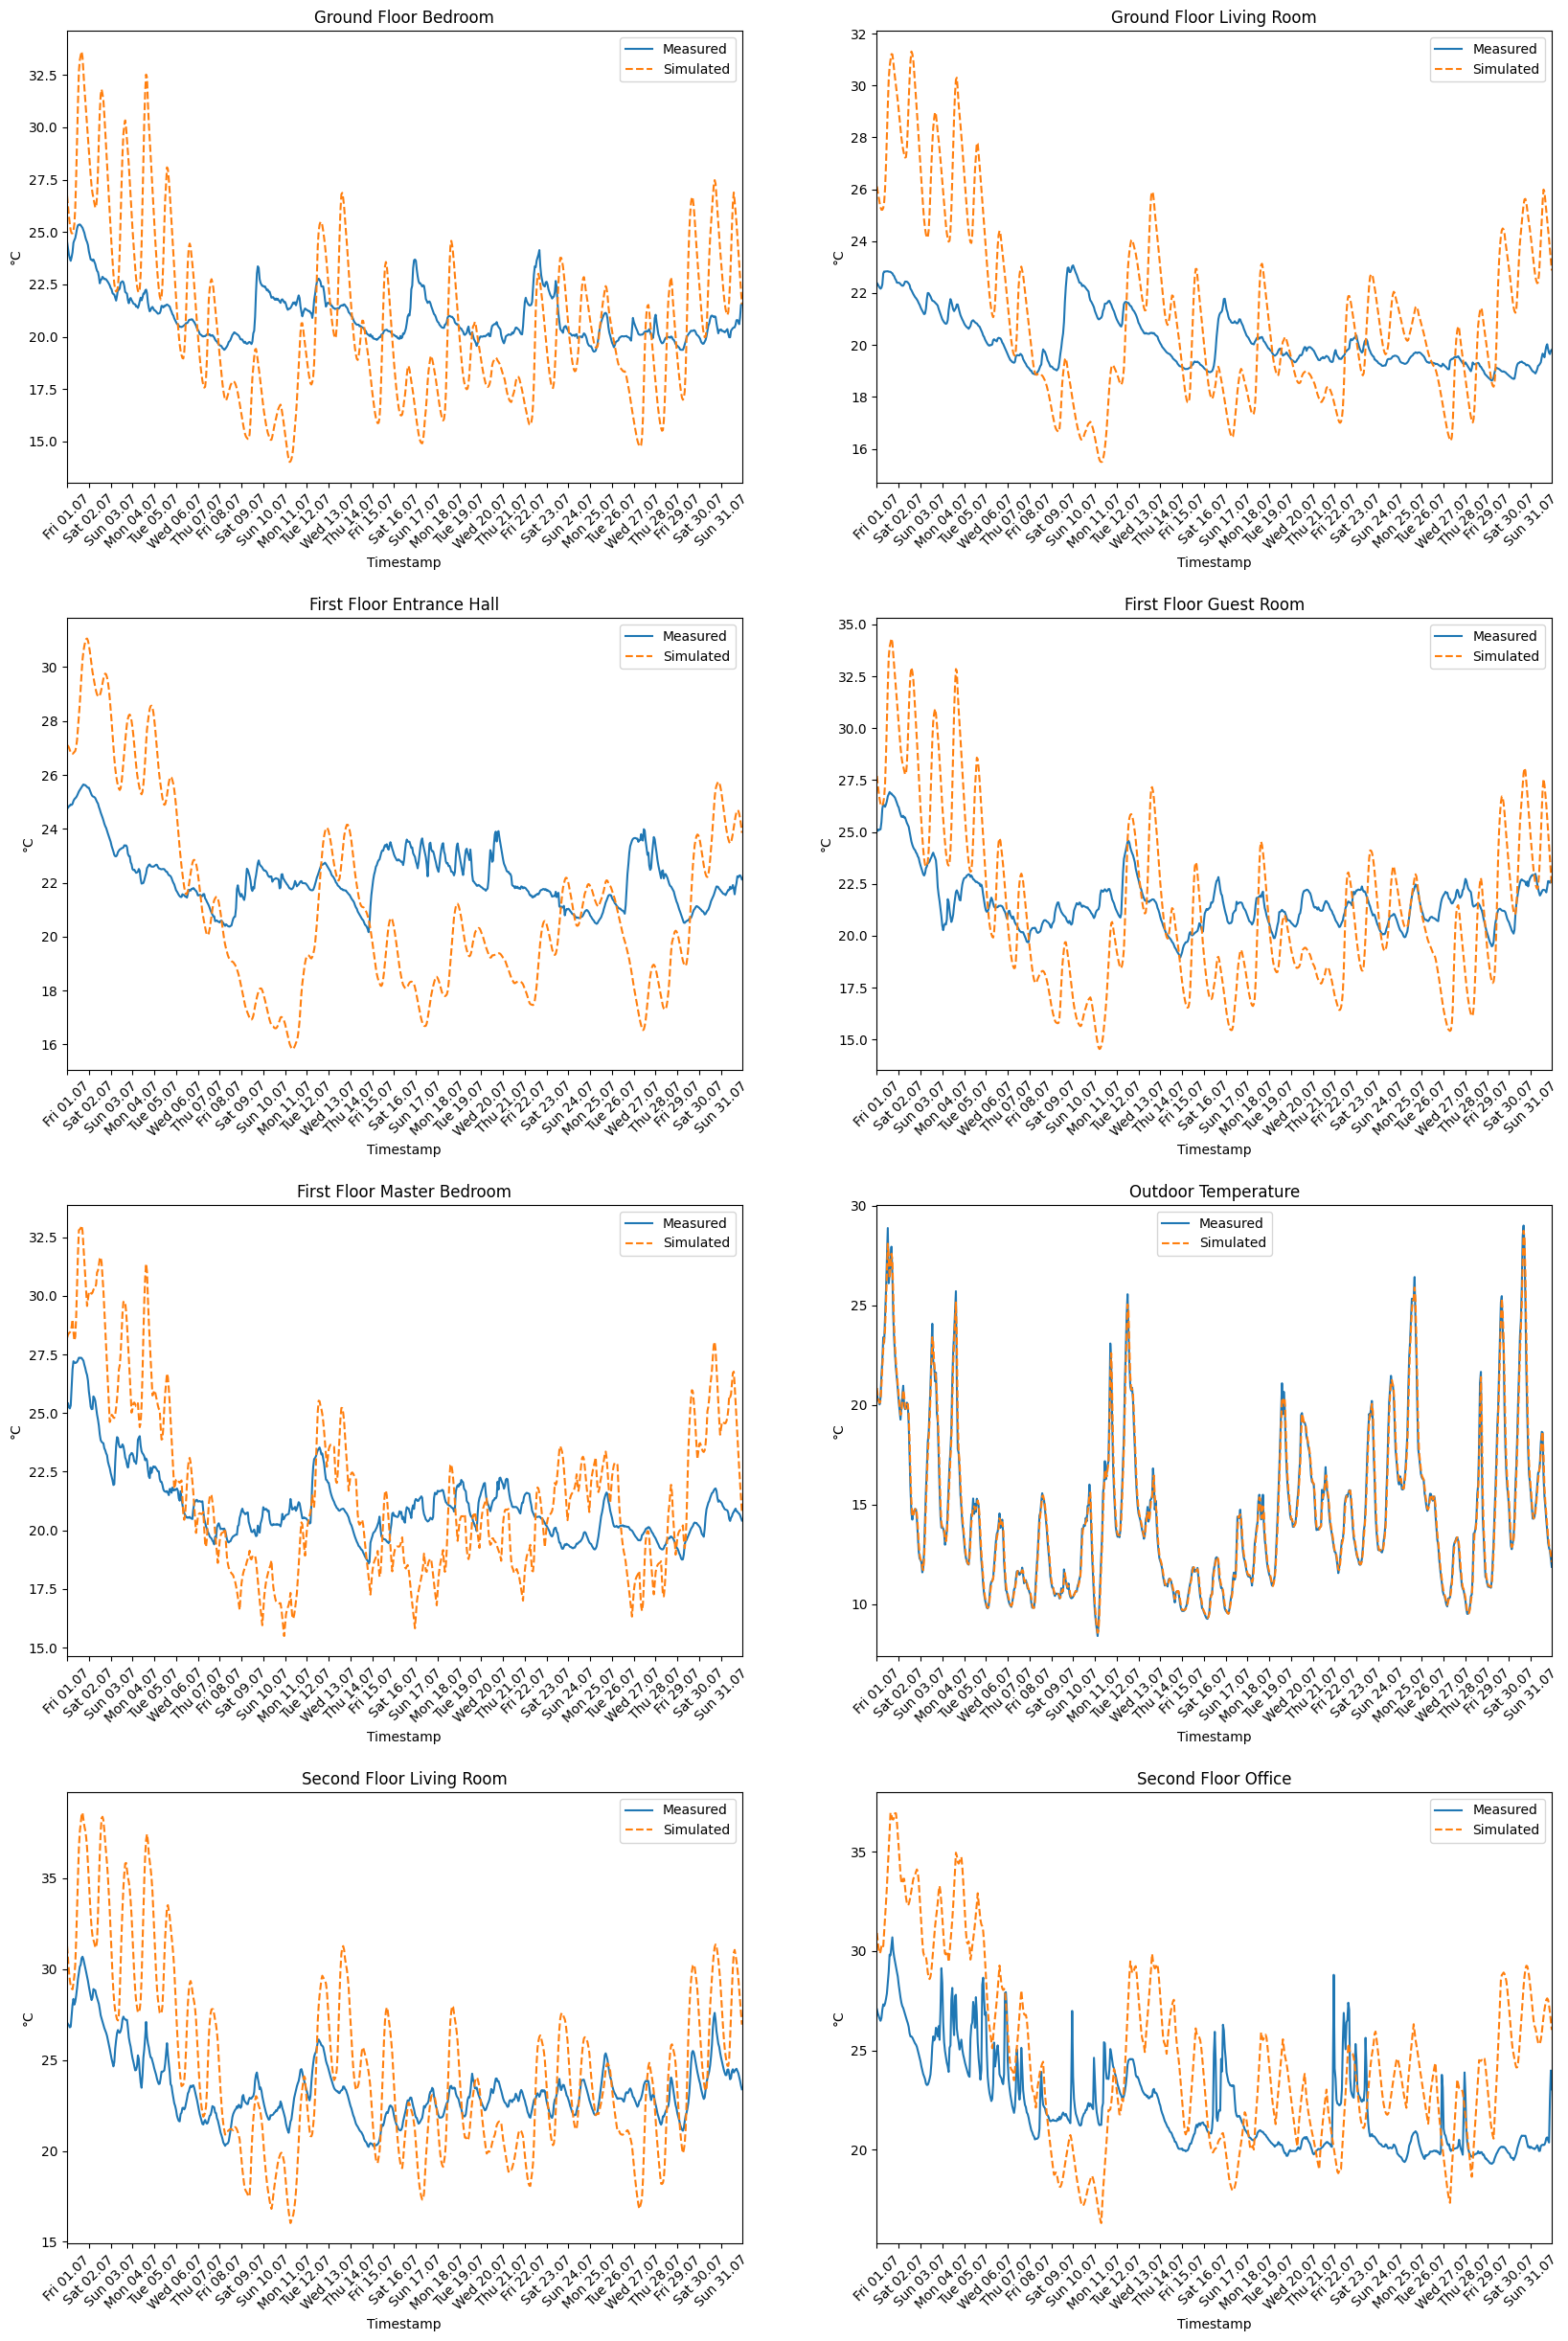

In [123]:
fig, axs = plt.subplots(4, 2, figsize=(20, 30))
plt.subplots_adjust(hspace=0.3)
titles = ["Ground Floor Bedroom", "Ground Floor Living Room", "First Floor Entrance Hall", "First Floor Guest Room", "First Floor Master Bedroom", "Outdoor Temperature", "Second Floor Living Room", "Second Floor Office"]

for i in range(len(sensor_data.columns)):
    axs[i//2][i%2].plot(sensor_data[sensor_data.columns[i]],)
    axs[i//2][i%2].plot(sim_temp[sim_temp.columns[i]], linestyle="dashed")
    axs[i//2][i%2].set_xticks(sensor_data.index[::24], [date.strftime("%a %d.%m") for date in sensor_data.index[::24].date], rotation=45)
    axs[i//2][i%2].margins(x=0)
    axs[i//2][i%2].legend(["Measured", "Simulated"])
    axs[i//2][i%2].set_xlabel("Timestamp")
    axs[i//2][i%2].set_ylabel("°C")
    axs[i//2][i%2].set_title(titles[i])
    axs[i//2][i%2]

plt.savefig("./plots/measured_vs_sim.pdf", bbox_inches='tight')

In [124]:
i = 0
filenames = ["ground_floor_bedroom_sim.pdf", "ground_floor_living_room_sim.pdf", 
             "first_floor_entrance_hall_sim.pdf", "first_floor_guest_room_sim.pdf", 
             "first_floor_master_bedroom_sim.pdf", "outdoor_temperature_sim.pdf", 
             "second_floor_living_room_sim.pdf", "second_floor_office_sim.pdf"]

for i in range(len(filenames)):
    plt.figure(figsize=(10, 5))
    plt.plot(sensor_data[sensor_data.columns[i]])
    plt.plot(sim_temp[sim_temp.columns[i]], linestyle="dashed")
    plt.xticks(sensor_data.index[::24], [date.strftime("%a %d.%m") for date in sensor_data.index[::24].date], rotation=45)
    plt.margins(x=0)
    plt.legend(["Meassured", "Simulated"])
    plt.xlabel("Timestamp")
    plt.ylabel("°C")
    plt.savefig(f"./plots/{filenames[i]}", bbox_inches='tight')
    _ = plt.clf()

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>